In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import time
from seaborn.widgets import cubehelix_palette
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

# 1. Leitura dos datasets

Realizaremos a leitura dos datasets em seu formato filtrado com as variáveis mais correlacionadas com o target **(df_processed)** e do dataset sem a filtragem **(df_bruto)**.

In [15]:
df_processed = pd.read_csv('data\Training Data_processed.csv')
df_processed = df_processed.drop('Unnamed: 0', axis=1)
df_bruto = pd.read_csv('data\Training Data_bruto.csv')
df_bruto = df_bruto.drop('Unnamed: 0', axis=1)

# 2. Definição das funções de treinamento

A seguir aplicaremos os datasets aos modelos com o auxílio das funções citadas.

A função `treinamento_modelo` recebe um estimador de aprendizado de máquina, dados de treinamento `X_train` e rótulos `y_train`, treina o modelo com esses dados e retorna o modelo treinado e o tempo de treinamento em segundos.

A função `analise_modelos` recebe uma lista de dicionários contendo informações sobre os modelos a serem treinados, o conjunto de dados `X` e os rótulos `y`. Ela realiza as seguintes etapas para cada modelo na lista:

1. Para cada iteração de uma validação cruzada externa (repetida 5 vezes):
   - Divide o conjunto de dados em conjuntos de treinamento e teste.
   - Treina o modelo usando `treinamento_modelo`.
   - Avalia o modelo nos dados de teste, calculando métricas como acurácia, precisão, revocação, F1-score e AUC.
   - Armazena as métricas calculadas.

2. Calcula as médias e desvios padrão das métricas para cada modelo.

3. Plota a curva ROC-AUC para cada modelo.

4. Retorna um dicionário com as métricas de desempenho de cada modelo.

A lista `lista_modelos` contém os modelos a serem treinados, cada um especificado com um nome, um estimador e uma grade de parâmetros para busca em grade.

**Modelos de classificação utilizados**

1. **Decision Tree (Árvore de Decisão):** Um modelo que divide o conjunto de dados em subconjuntos menores com base em características específicas, buscando criar um modelo que faça previsões com base nessas divisões. Os parâmetros incluem a profundidade máxima da árvore.

2. **XGBoost:** Um algoritmo de gradient boosting que é eficaz em muitos problemas de modelagem preditiva. Ele constrói vários modelos de árvore de decisão fracos e os combina para obter um modelo forte. Os parâmetros incluem a profundidade máxima da árvore.

3. **KNN (K-Nearest Neighbors):** Um algoritmo que classifica os pontos de dados com base nos pontos de dados mais próximos no espaço de características. Os parâmetros incluem o número de vizinhos considerados para a classificação.

4. **Random Forest:** Um modelo que consiste em um conjunto de árvores de decisão, onde a previsão final é a média das previsões de cada árvore. Os parâmetros incluem o número de árvores na floresta.

Cada um desses modelos é treinado e avaliado usando uma validação cruzada para garantir uma avaliação robusta do desempenho.


In [27]:
def treinamento_modelo(estimador, X_train, y_train):
    """
    Treina um modelo com os dados de treinamento.

    Args:
        estimador: Um modelo de aprendizado de máquina (classificador/regressor).
        X_train: Dados de treinamento.
        y_train: Rótulos de treinamento.

    Returns:
        estimador_treinado: O modelo treinado.
        tempo_treinamento: O tempo de treinamento em segundos.
    """
    inicio_treinamento = time.time()
    estimador_treinado = estimador.fit(X_train, y_train)
    fim_treinamento = time.time()
    tempo_treinamento = fim_treinamento - inicio_treinamento
    return estimador_treinado, tempo_treinamento

def analise_modelos(lista_modelos, X, y):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota a curva ROC-AUC e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X: Conjunto de dados.
        y: Rótulos.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****\n")

    resultados_por_iteracao = []  # Lista para armazenar os resultados de cada iteração

    # Lista para armazenar os valores de fpr e tpr de cada modelo
    fpr_list = []
    tpr_list = []

    # Repetindo o processo completo 5 vezes
    for i in range(5):
        print(f"Iteração {i+1}/5:")
        
        # Configurando a validação cruzada externa
        cv_outer = KFold(n_splits=10, shuffle=True, random_state=i)

        resultados_iteracao = {}  # Dicionário para armazenar os resultados desta iteração

        # Configurando a busca em grade dentro de cada iteração da validação cruzada externa
        for mdl in lista_modelos:
            nome_do_modelo = mdl["nome_do_modelo"]
            estimador = mdl.get('estimador')
            parametros = mdl.get('parametros')

            # Listas para armazenar métricas de interesse em cada fold
            accuracy_list = []
            precision_list = []
            recall_list = []
            f1_score_list = []

            # Configurando a busca em grade
            grid_search = GridSearchCV(estimador, parametros, scoring='recall', cv=KFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1)

            # Executando a validação cruzada
            cv_results = []
            tempos_de_treinamento = []
            for train_ix, test_ix in cv_outer.split(X):
                X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
                y_train, y_test = y[train_ix], y[test_ix]

                # Capturando tempo de treinamento
                modelo_treinado, tempo_treinamento = treinamento_modelo(grid_search, X_train, y_train)
                tempos_de_treinamento.append(tempo_treinamento)

                # Avaliação do modelo no conjunto de teste
                y_pred = modelo_treinado.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)

                # Armazenando métricas deste fold
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_score_list.append(f1)

                y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
                fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)  # Calcula FPR e TPR
                auc_score = metrics.roc_auc_score(y_test, y_pred_proba)  # Calcula AUC
                cv_results.append(auc_score)

                # Adicionando os valores de fpr e tpr à lista
                fpr_list.append(fpr)
                tpr_list.append(tpr)

            # Calculando as médias e desvios padrão das métricas
            accuracy_mean = np.mean(accuracy_list)
            accuracy_std = np.std(accuracy_list)
            precision_mean = np.mean(precision_list)
            precision_std = np.std(precision_list)
            recall_mean = np.mean(recall_list)
            recall_std = np.std(recall_list)
            f1_score_mean = np.mean(f1_score_list)
            f1_score_std = np.std(f1_score_list)

            auc_mean = np.mean(cv_results)
            auc_std = np.std(cv_results)

            print(f"Modelo     : {nome_do_modelo}")
            print(f"Acurácia   : {accuracy_mean:.5f} +/- {accuracy_std:.5f}")
            print(f"Precisão   : {precision_mean:.5f} +/- {precision_std:.5f}")
            print(f"Revocação  : {recall_mean:.5f} +/- {recall_std:.5f}")
            print(f"F1 - Score : {f1_score_mean:.5f} +/- {f1_score_std:.5f}")
            print(f"ROC - AUC  : {auc_mean:.5f} +/- {auc_std:.5f}")
            print(f"Tempo médio de treinamento: {np.mean(tempos_de_treinamento):.5f} segundos\n\n{'='*50}\n")

            resultados_iteracao[mdl.get('nome_do_modelo')]  = {
                "Acurácia_mean": accuracy_mean,
                "Acurácia_std": accuracy_std,
                "Precisão_mean": precision_mean,
                "Precisão_std": precision_std,
                "Revocação_mean": recall_mean,
                "Revocação_std": recall_std,
                "f1_score_mean": f1_score_mean,
                "f1_score_std": f1_score_std,
                "auc_mean": auc_mean,
                "auc_std": auc_std,
                "tempo_medio_treinamento": np.mean(tempos_de_treinamento)
            }
        # Adicionando os resultados desta iteração à lista de resultados
        resultados_por_iteracao.append(resultados_iteracao)

    # Plotagem da curva ROC geral
    plt.figure(figsize=(10, 8))  # Ajusta o tamanho da figura
    for fpr, tpr, mdl in zip(fpr_list, tpr_list, lista_modelos):
        plt.plot(fpr, tpr, label='%s ROC' % mdl["nome_do_modelo"])
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('CURVA ROC-AUC')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()

    return resultados_por_iteracao

# Lista de modelos com parâmetros para busca em grade
lista_modelos = [
    {
        "nome_do_modelo": "Decision Tree",
        "estimador": DecisionTreeClassifier(),
        "parametros": {'max_depth': [3, 5, 7]}
    },
    {
        "nome_do_modelo": "XGBoost",
        "estimador": XGBClassifier(),
        "parametros": {'max_depth': [3, 5, 7]}
    },
    {
        "nome_do_modelo": "KNN",
        "estimador": KNeighborsClassifier(),
        "parametros": {'n_neighbors': [3, 5, 7]}
    },
    {
        "nome_do_modelo": "Random Forest",
        "estimador": RandomForestClassifier(),
        "parametros": {'n_estimators': [50, 100, 200]}
    }
]

## 2.1. Aplicando o dataset filtrado




 **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****

Iteração 1/5:
Modelo     : Decision Tree
Acurácia   : 0.87714 +/- 0.00100
Precisão   : 0.53104 +/- 0.03395
Revocação  : 0.00916 +/- 0.00249
F1 - Score : 0.01798 +/- 0.00482
ROC - AUC  : 0.59710 +/- 0.00851
Tempo médio de treinamento: 1.78726 segundos


Modelo     : XGBoost
Acurácia   : 0.88042 +/- 0.00139
Precisão   : 0.58623 +/- 0.02172
Revocação  : 0.09465 +/- 0.00600
F1 - Score : 0.16293 +/- 0.00932
ROC - AUC  : 0.83803 +/- 0.00253
Tempo médio de treinamento: 5.26840 segundos


Modelo     : KNN
Acurácia   : 0.86413 +/- 0.00216
Precisão   : 0.45191 +/- 0.00697
Revocação  : 0.49023 +/- 0.01144
F1 - Score : 0.47018 +/- 0.00562
ROC - AUC  : 0.81051 +/- 0.00440
Tempo médio de treinamento: 106.99008 segundos


Modelo     : Random Forest
Acurácia   : 0.87905 +/- 0.00134
Precisão   : 0.51445 +/- 0.00954
Revocação  : 0.29641 +/- 0.01130
F1 - Score : 0.37601 +/- 0.01062
ROC - AUC  : 0.86708 +/- 0.00413
Tempo médio de treinamento: 64.46889 s

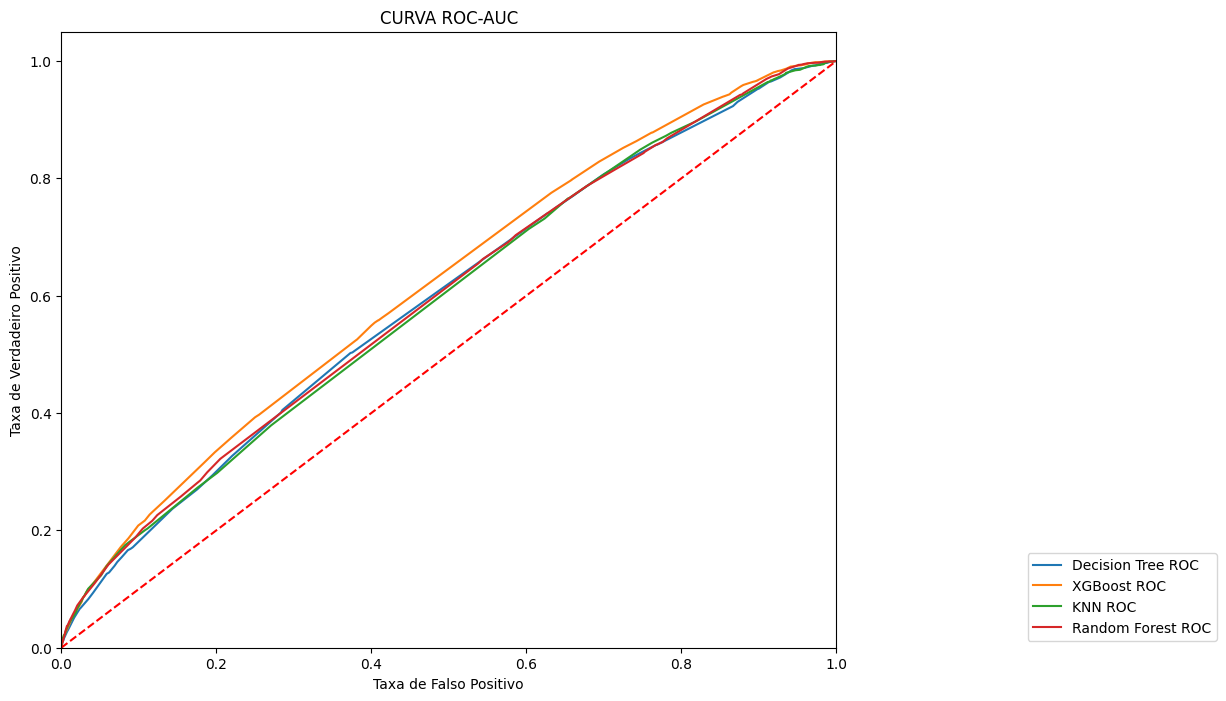

[{'Decision Tree': {'Acurácia_mean': 0.8771388888888889,
   'Acurácia_std': 0.0010042819009413275,
   'Precisão_mean': 0.5310422384380515,
   'Precisão_std': 0.03395148286255027,
   'Revocação_mean': 0.009156917995330105,
   'Revocação_std': 0.0024871268994630766,
   'f1_score_mean': 0.017984604688721956,
   'f1_score_std': 0.004819427163142812,
   'auc_mean': 0.5971010082383911,
   'auc_std': 0.008505093020435162,
   'tempo_medio_treinamento': 1.7872639894485474},
  'XGBoost': {'Acurácia_mean': 0.8804206349206349,
   'Acurácia_std': 0.0013883445645377903,
   'Precisão_mean': 0.5862328232230226,
   'Precisão_std': 0.021724339582523806,
   'Revocação_mean': 0.09465089369806254,
   'Revocação_std': 0.005995212694093402,
   'f1_score_mean': 0.1629295587729263,
   'f1_score_std': 0.009318138332480153,
   'auc_mean': 0.8380332745550522,
   'auc_std': 0.002534066351465683,
   'tempo_medio_treinamento': 5.268396878242493},
  'KNN': {'Acurácia_mean': 0.8641269841269841,
   'Acurácia_std': 0.00

In [28]:
# Remover a coluna risk_flag dos dados, extraindo as features na variável X
X = df_processed.drop(['risk_flag'], axis = 1)
y = df_processed['risk_flag']

# Padronização/Normalizando dos dados utilizando o StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns)

result_processed_5 = analise_modelos(lista_modelos, X_std, y)
result_processed_5

## 2.2 Aplicando o dataset bruto




 **** RESULTADO DOS MODELOS + CURVA ROC-AUC ****

Iteração 1/5:
Modelo     : Decision Tree
Acurácia   : 0.87688 +/- 0.00100
Precisão   : 0.35993 +/- 0.17039
Revocação  : 0.00142 +/- 0.00092
F1 - Score : 0.00282 +/- 0.00182
ROC - AUC  : 0.68577 +/- 0.00722
Tempo médio de treinamento: 2.50890 segundos


Modelo     : XGBoost
Acurácia   : 0.94316 +/- 0.00187
Precisão   : 0.92894 +/- 0.00607
Revocação  : 0.58247 +/- 0.01454
F1 - Score : 0.71588 +/- 0.01113
ROC - AUC  : 0.96331 +/- 0.00206
Tempo médio de treinamento: 6.67376 segundos


Modelo     : KNN
Acurácia   : 0.88791 +/- 0.00237
Precisão   : 0.54963 +/- 0.00997
Revocação  : 0.49219 +/- 0.00818
F1 - Score : 0.51928 +/- 0.00755
ROC - AUC  : 0.84310 +/- 0.00489
Tempo médio de treinamento: 114.62571 segundos


Modelo     : Random Forest
Acurácia   : 0.90980 +/- 0.00165
Precisão   : 0.69673 +/- 0.01065
Revocação  : 0.47243 +/- 0.01103
F1 - Score : 0.56296 +/- 0.00869
ROC - AUC  : 0.92970 +/- 0.00207
Tempo médio de treinamento: 241.99285 

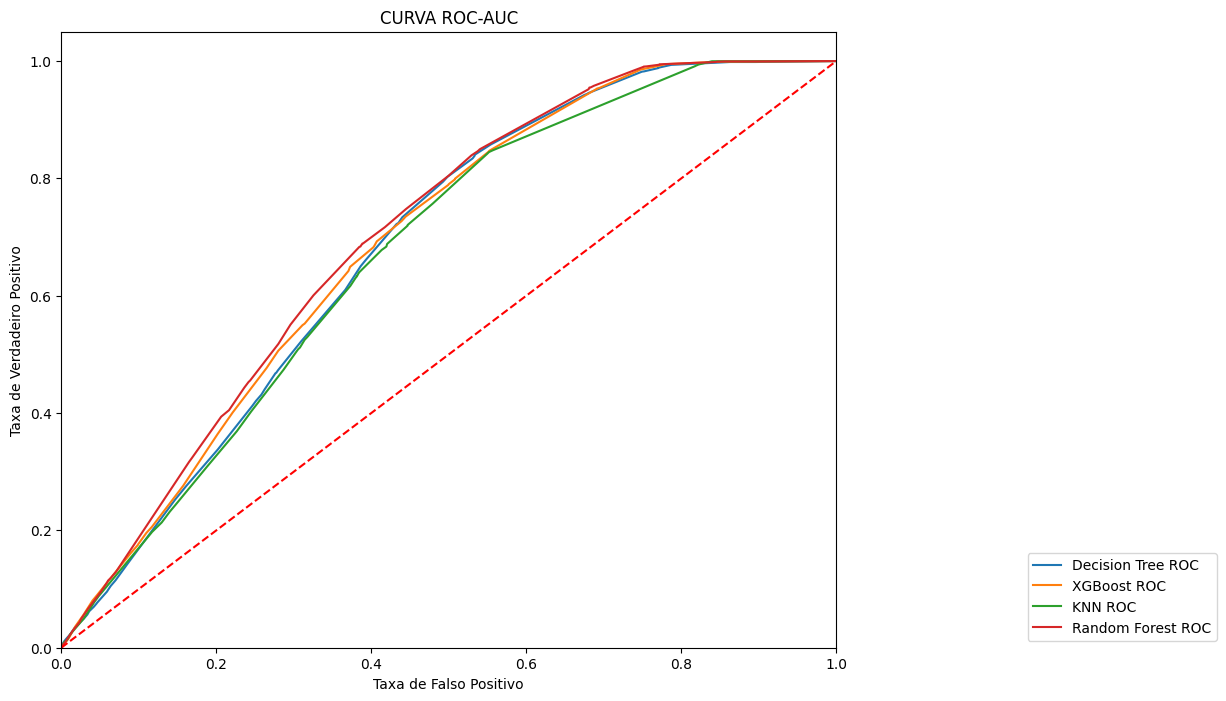

[{'Decision Tree': {'Acurácia_mean': 0.876876984126984,
   'Acurácia_std': 0.0009988734521166355,
   'Precisão_mean': 0.3599310134310134,
   'Precisão_std': 0.1703936357205596,
   'Revocação_mean': 0.0014164634791016951,
   'Revocação_std': 0.0009167093552624257,
   'f1_score_mean': 0.0028191148702327085,
   'f1_score_std': 0.0018183677312461131,
   'auc_mean': 0.6857685752365882,
   'auc_std': 0.0072188542172974355,
   'tempo_medio_treinamento': 2.508902382850647},
  'XGBoost': {'Acurácia_mean': 0.9431587301587301,
   'Acurácia_std': 0.001874192527902432,
   'Precisão_mean': 0.9289437818968734,
   'Precisão_std': 0.00606650634038671,
   'Revocação_mean': 0.5824687927076374,
   'Revocação_std': 0.014536638789454595,
   'f1_score_mean': 0.7158839467894357,
   'f1_score_std': 0.011134306036913835,
   'auc_mean': 0.963305468478574,
   'auc_std': 0.002060552127069548,
   'tempo_medio_treinamento': 6.673763155937195},
  'KNN': {'Acurácia_mean': 0.8879087301587301,
   'Acurácia_std': 0.00236

In [29]:
# Remover a coluna risk_flag dos dados, extraindo as features na variável X
X_bruto = df_bruto.drop(['risk_flag'], axis = 1)
y_bruto = df_bruto['risk_flag']

# Padronização/Normalizando dos dados utilizando o StandardScaler
scaler = StandardScaler()
X_std_bruto = scaler.fit_transform(X_bruto)
X_std_bruto = pd.DataFrame(X_std_bruto, index=X_bruto.index, columns=X_bruto.columns)

result_processed_bruto_5 = analise_modelos(lista_modelos, X_std_bruto, y_bruto)
result_processed_bruto_5

# 3. Extraindo e salvando os resultados

In [35]:
# Inicializa um dataframe vazio
df_processed_results = pd.DataFrame()

# Loop sobre cada elemento da lista
for i, resultado in enumerate(result_processed_5, start=1):
    # Adiciona a iteração como uma coluna no dataframe
    for modelo, metricas in resultado.items():
        if df_processed_results.empty:
            df_processed_results['Iteração'] = i
            df_processed_results = df_processed_results.set_index('Iteração')
            df_processed_results.loc[i, 'Modelo'] = modelo
            for metrica, valor in metricas.items():
                df_processed_results.loc[i, metrica] = valor
        else:
            temp_df = pd.DataFrame(columns=df_processed_results.columns)
            temp_df.loc[1, 'Modelo'] = modelo
            for metrica, valor in metricas.items():
                temp_df.loc[1, metrica] = valor
            temp_df['Iteração'] = i
            temp_df = temp_df.set_index('Iteração')
            df_processed_results = pd.concat([df_processed_results, temp_df])

In [40]:
df_processed_results.to_csv('data/result_processed.csv')

In [37]:
# Inicializa um dataframe vazio
df_bruto_results = pd.DataFrame()

# Loop sobre cada elemento da lista
for i, resultado in enumerate(result_processed_bruto_5, start=1):
    # Adiciona a iteração como uma coluna no dataframe
    for modelo, metricas in resultado.items():
        if df_bruto_results.empty:
            df_bruto_results['Iteração'] = i
            df_bruto_results = df_bruto_results.set_index('Iteração')
            df_bruto_results.loc[i, 'Modelo'] = modelo
            for metrica, valor in metricas.items():
                df_bruto_results.loc[i, metrica] = valor
        else:
            temp_df = pd.DataFrame(columns=df_bruto_results.columns)
            temp_df.loc[1, 'Modelo'] = modelo
            for metrica, valor in metricas.items():
                temp_df.loc[1, metrica] = valor
            temp_df['Iteração'] = i
            temp_df = temp_df.set_index('Iteração')
            df_bruto_results = pd.concat([df_bruto_results, temp_df])

In [39]:
df_bruto_results.to_csv('data/result_bruto.csv')

# 4. Analisando os resultados

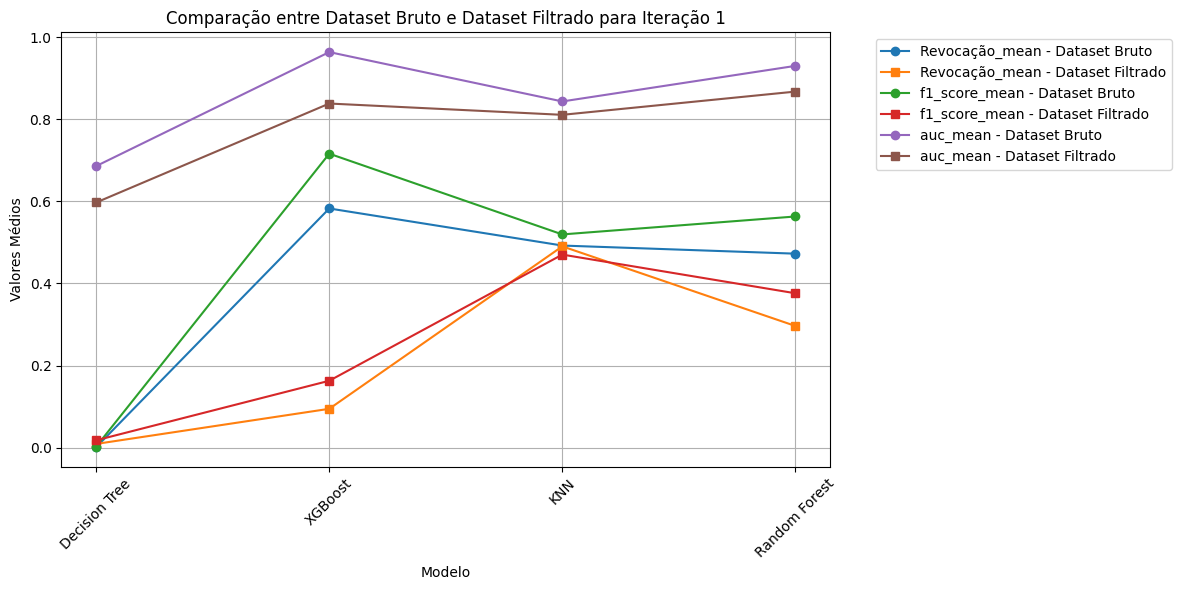

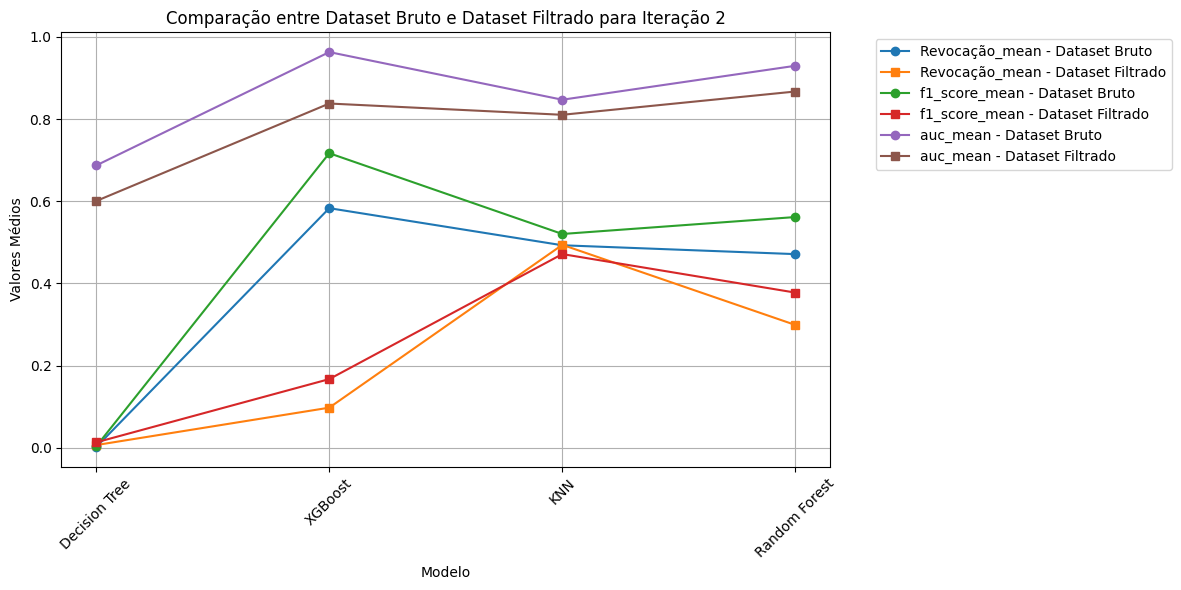

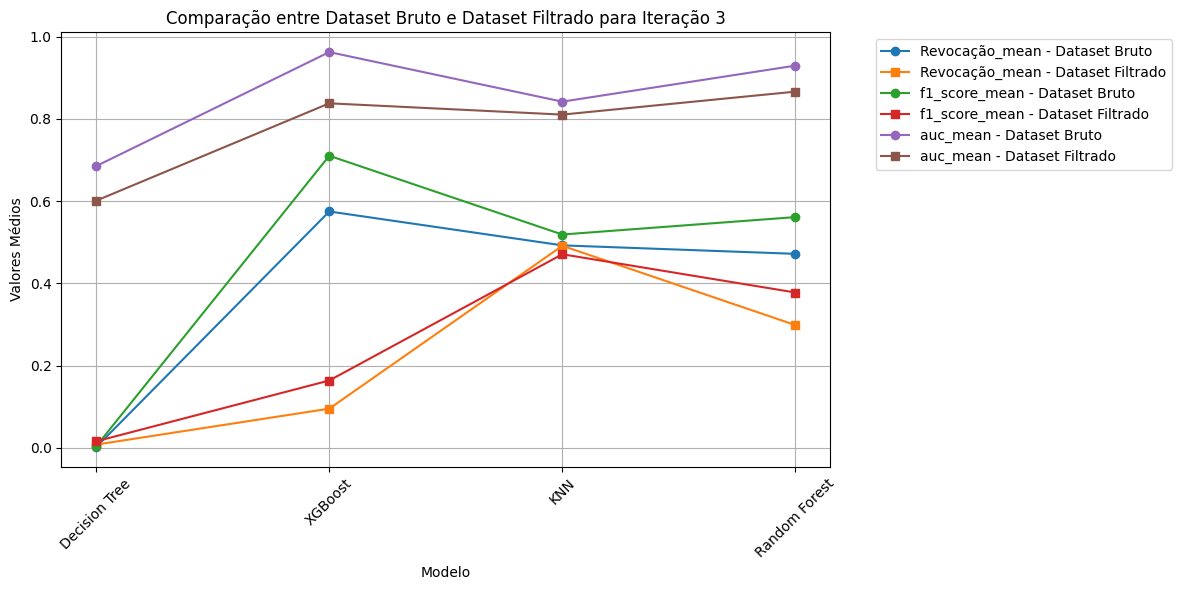

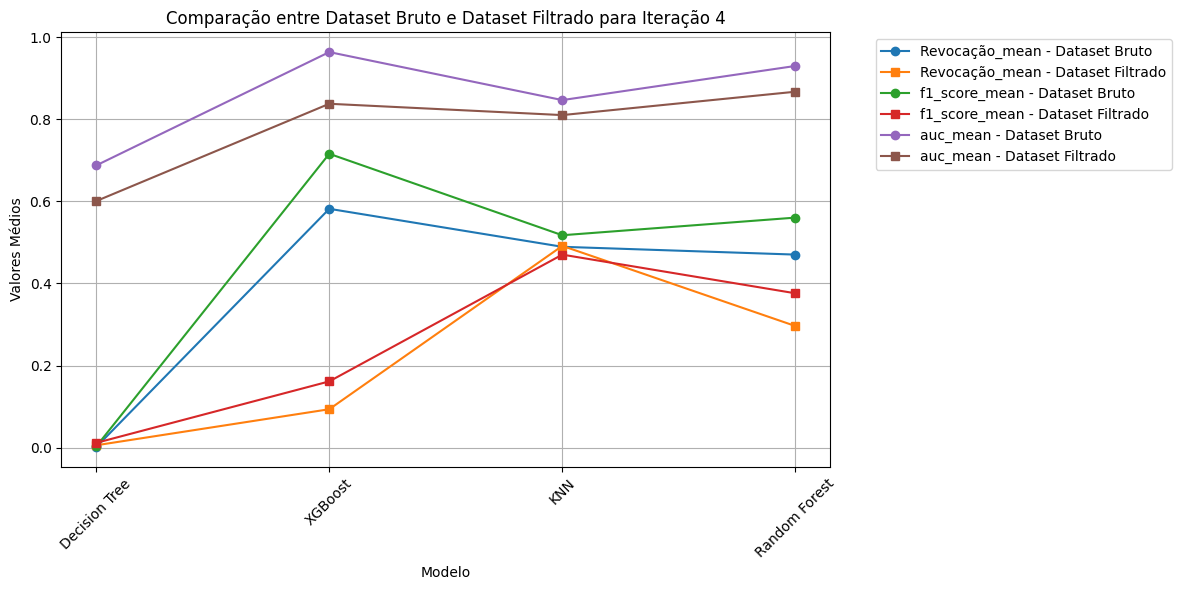

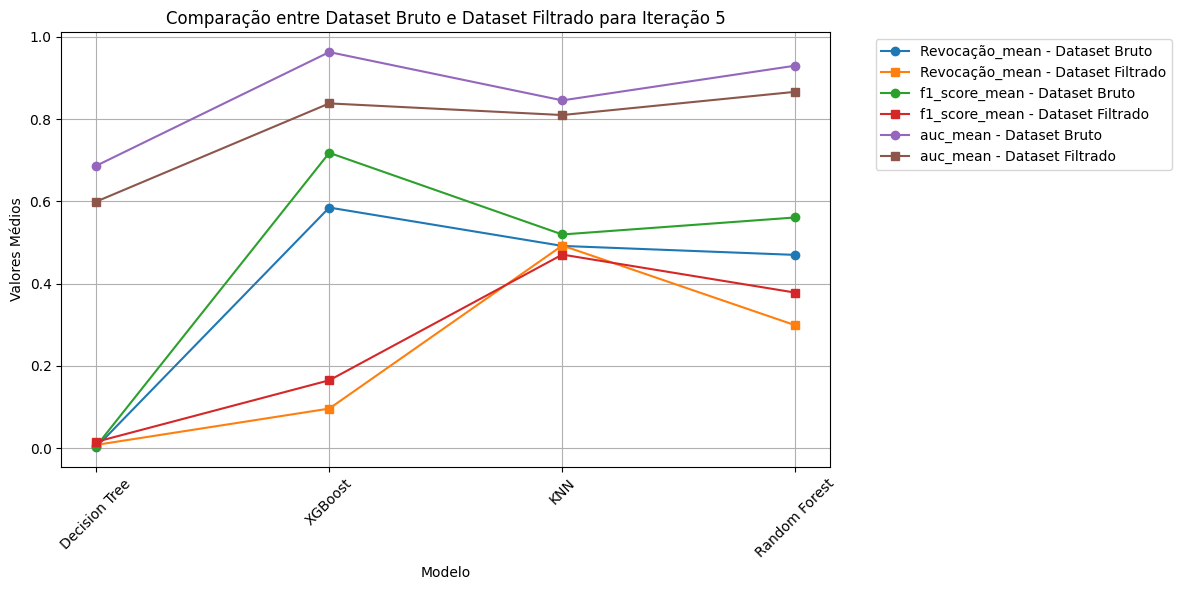

In [63]:
df_bruto = pd.read_csv('data/result_bruto.csv')
df_filtrado = pd.read_csv('data/result_processed.csv')

# Convertendo as colunas para valores numéricos
numeric_columns = ['Acurácia_mean', 'Precisão_mean', 'Revocação_mean', 'f1_score_mean', 'auc_mean', 'tempo_medio_treinamento']
for col in numeric_columns:
    df_bruto[col] = pd.to_numeric(df_bruto[col])
    df_filtrado[col] = pd.to_numeric(df_filtrado[col])

# Listando as iterações
iteracoes = df_bruto['Iteração'].unique()

# Criando os gráficos
for iteracao in iteracoes:
    df_bruto_iteracao = df_bruto[df_bruto['Iteração'] == iteracao]
    df_filtrado_iteracao = df_filtrado[df_filtrado['Iteração'] == iteracao]

    plt.figure(figsize=(12, 6))
    metrics = ['Revocação_mean', 'f1_score_mean', 'auc_mean']
    for metric in metrics:
        plt.plot(df_bruto_iteracao['Modelo'], df_bruto_iteracao[metric], marker='o', label=f'{metric} - Dataset Bruto')
        plt.plot(df_filtrado_iteracao['Modelo'], df_filtrado_iteracao[metric], marker='s', label=f'{metric} - Dataset Filtrado')

    plt.xlabel('Modelo')
    plt.ylabel('Valores Médios')
    plt.title(f'Comparação entre Dataset Bruto e Dataset Filtrado para Iteração {iteracao}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

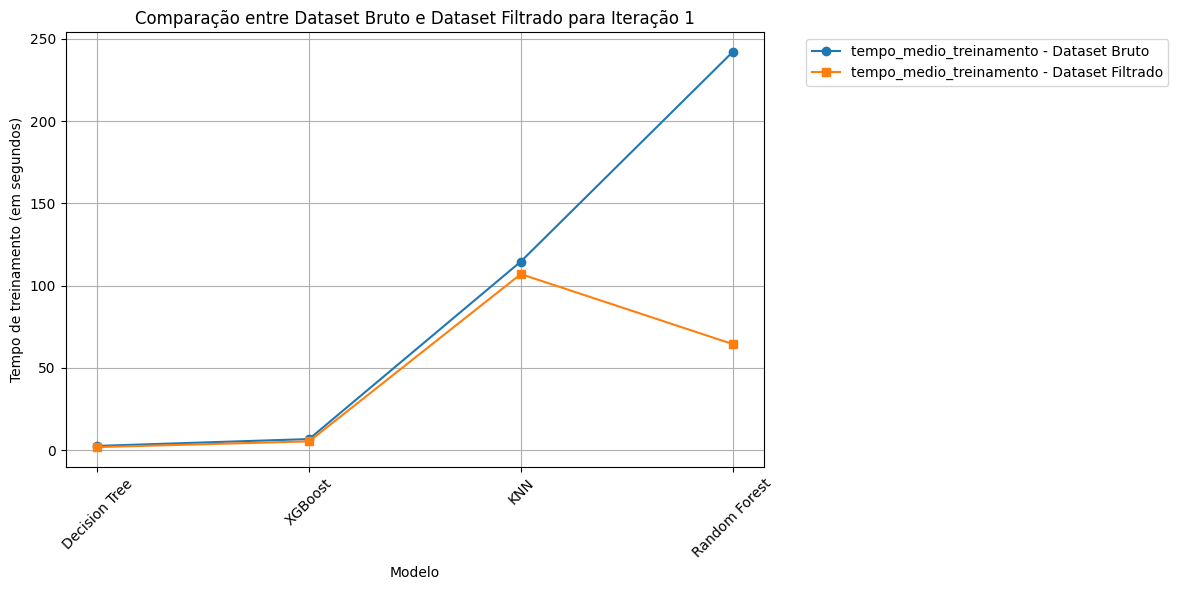

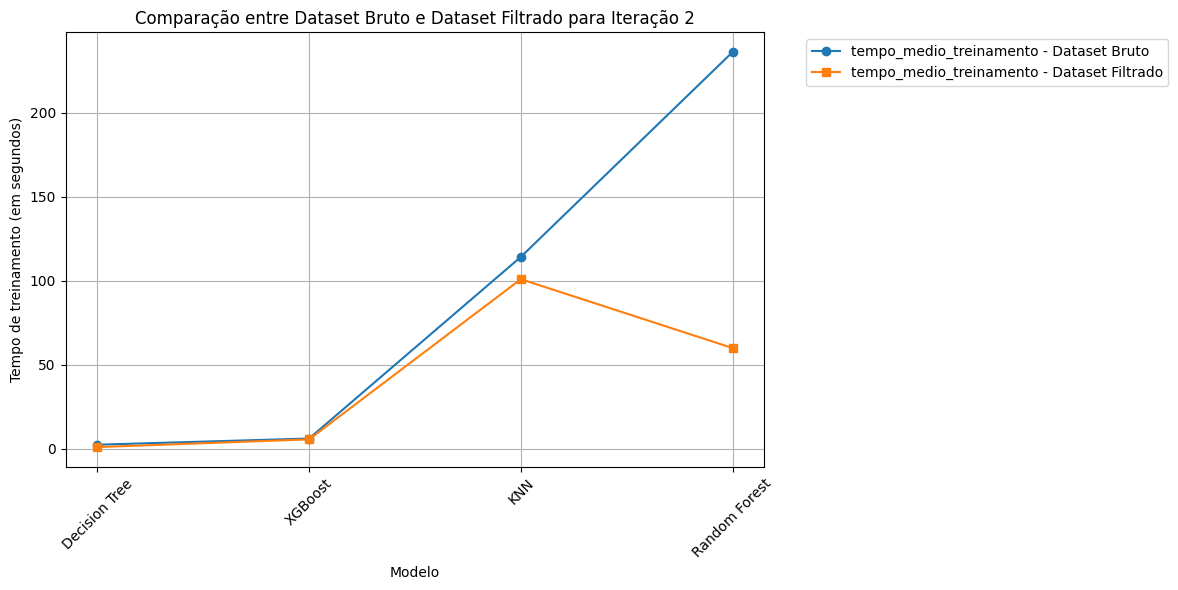

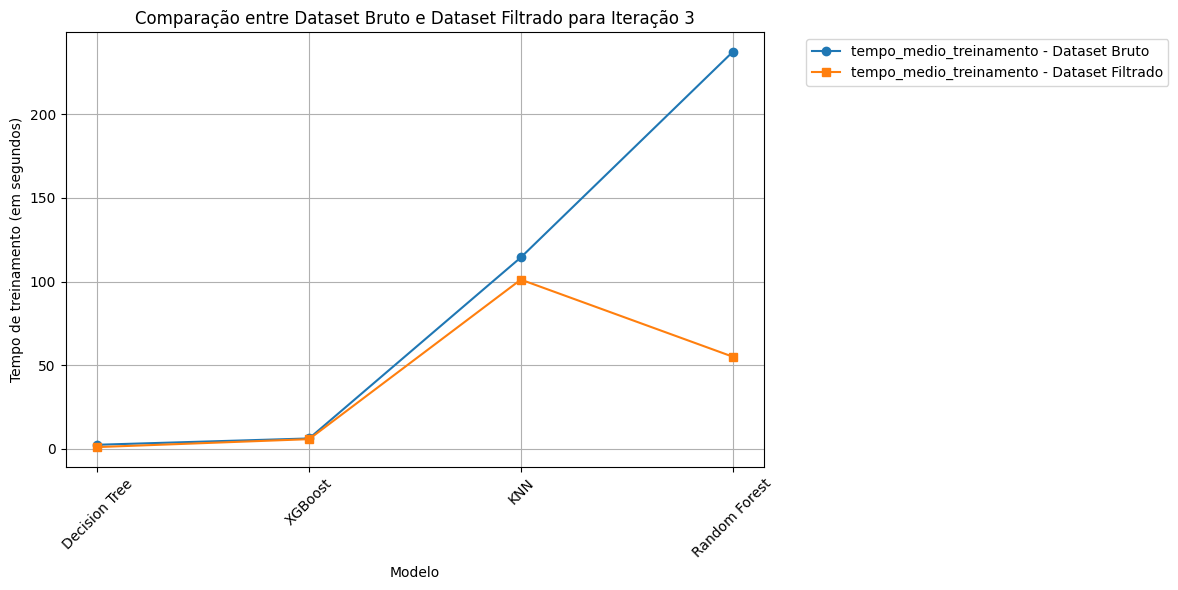

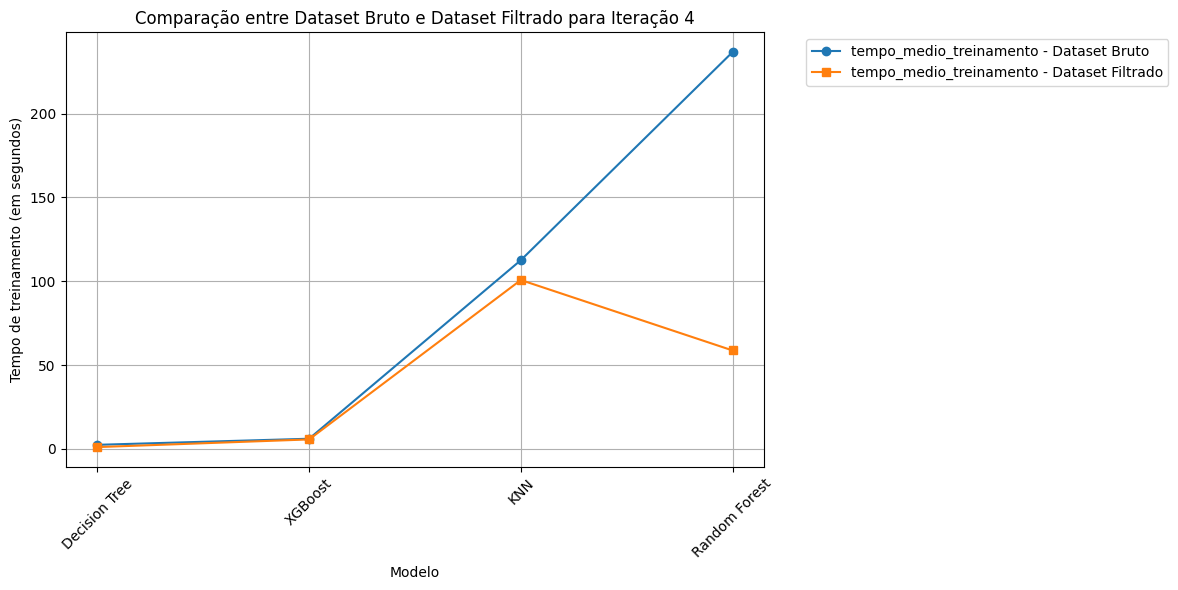

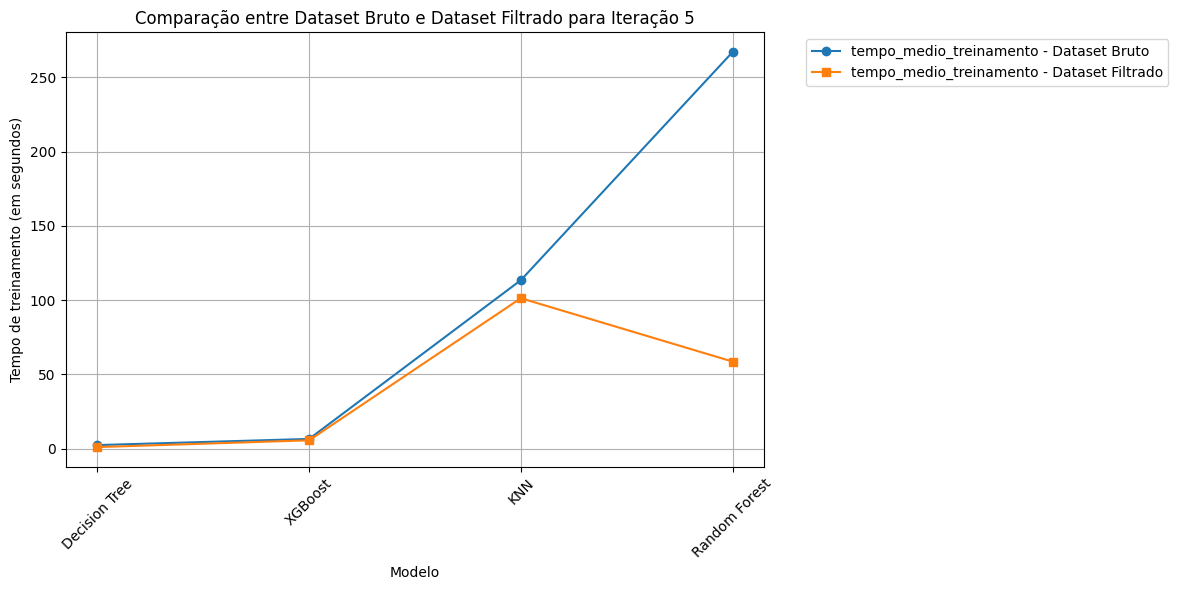

In [65]:
# Criando os gráficos
for iteracao in iteracoes:
    df_bruto_iteracao = df_bruto[df_bruto['Iteração'] == iteracao]
    df_filtrado_iteracao = df_filtrado[df_filtrado['Iteração'] == iteracao]

    plt.figure(figsize=(12, 6))
    metrics = ['tempo_medio_treinamento']
    for metric in metrics:
        plt.plot(df_bruto_iteracao['Modelo'], df_bruto_iteracao[metric], marker='o', label=f'{metric} - Dataset Bruto')
        plt.plot(df_filtrado_iteracao['Modelo'], df_filtrado_iteracao[metric], marker='s', label=f'{metric} - Dataset Filtrado')

    plt.xlabel('Modelo')
    plt.ylabel('Tempo de treinamento (em segundos)')
    plt.title(f'Comparação entre Dataset Bruto e Dataset Filtrado para Iteração {iteracao}')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()